# セマンティック・セグメンテーション
## 一般的な画像分類
画像全体に対して、この画像は何かを出力する。
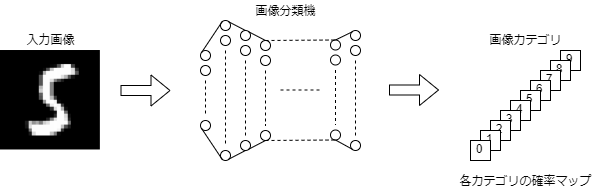

## セマンティック・セグメンテーション
画像のピクセルごとに、画像の種類を出力する。
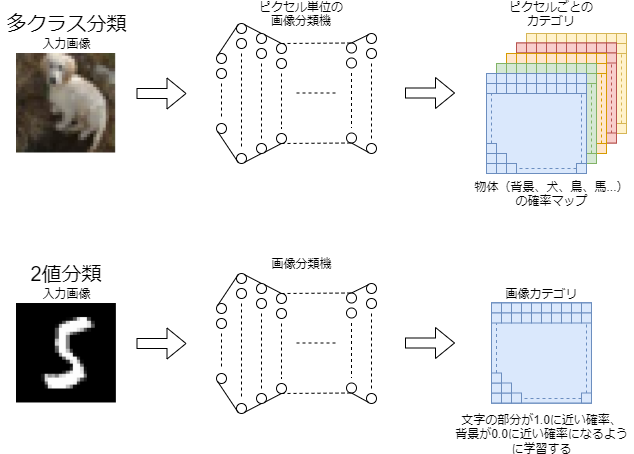

# ネットワーク層の違いについて
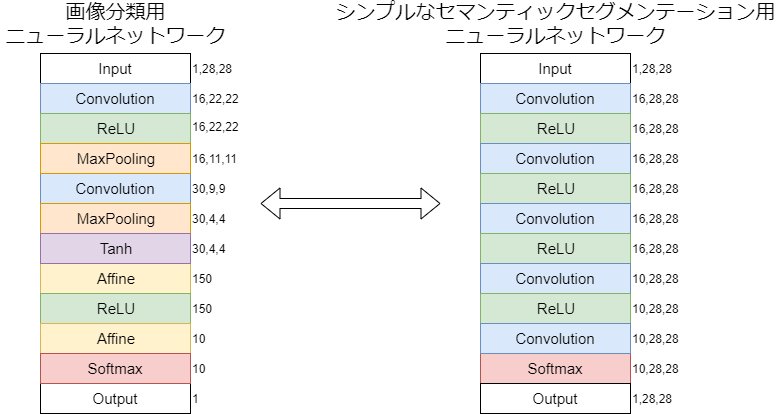

## シンプルなセマンティックセグメンテーションネットワークの課題
数層程度のニューラルネットワークでは、局所的な画像の特徴を元にした認識しか行うことができない。
または、広域な画像の特徴を元にした認識を行うためには、極端な多層化が必要になる。

## ダウンサンプリングによる画像参照領域の拡大
画像認識時と同様にダウンサンプリング処理を行うことで、広い画像領域を参照できるようになる。
一方で、認識結果の解像度は低下する。<br>
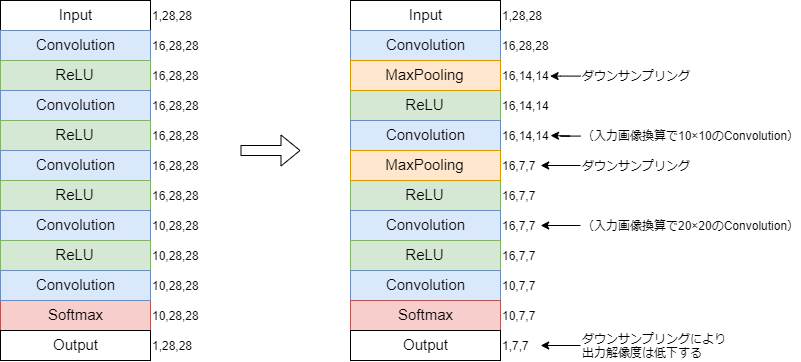

## 出力解像度と広い参照範囲を両立するネットワークの工夫
### ダウンサンプリング後にアップサンプリングを行い解像度を復元
MaxPoolingの逆の処理、UnPooling層をMaxPoolingと同じ数だけ用いることで、入力画像の解像度を復元する。しかし、ネットワークの途中で解像度を下げているため、復元した確率マップも解像度は元通りだが、ぼやけたような状態になる。<br>
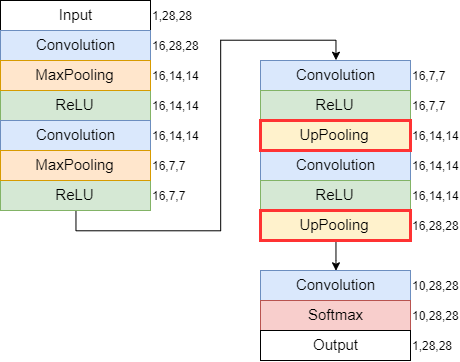

### Skip Connectionで解像度を保ったまま情報を後段に伝える
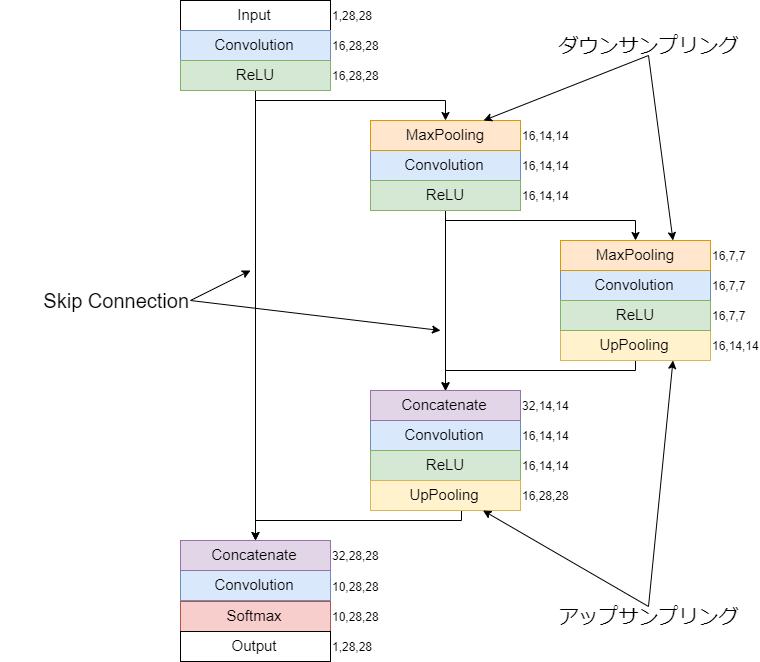

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST

In [2]:
def set_color(segmentation_image):
    rgb_image = np.zeros((28, 28, 3), np.uint8)
    for x, ps in enumerate(segmentation_image):
        for y, p in enumerate(ps):
            p = p - 1
            if p == 0:
                rgb_image[x, y, :] = [255, 255, 255]
            if p == 1:
                rgb_image[x, y, :] = [255,   0,   0]
            if p == 2:
                rgb_image[x, y, :] = [  0, 255,   0]
            if p == 3:
                rgb_image[x, y, :] = [  0,   0, 255]
            if p == 4:
                rgb_image[x, y, :] = [255, 255,   0]
            if p == 5:
                rgb_image[x, y, :] = [  0, 255, 255]
            if p == 6:
                rgb_image[x, y, :] = [255,   0, 255]
            if p == 7:
                rgb_image[x, y, :] = [127, 127,   0]
            if p == 8:
                rgb_image[x, y, :] = [  0, 127, 127]
            if p == 9:
                rgb_image[x, y, :] = [127,   0, 127]
    return rgb_image

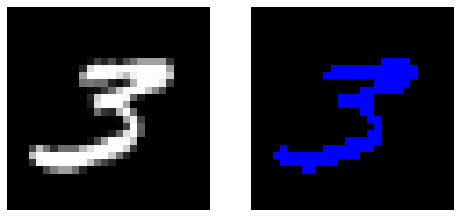

In [3]:
class SegmentationMNIST(Dataset):
    def __init__(self, root, train, threshold):
        super().__init__()
        self.mnist = MNIST(root = root, train = train)
        self.threshold = threshold
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, index):
        np_image = np.zeros((1, 28, 28), np.uint8)
        np_mask  = np.zeros((1, 28, 28), np.uint8)
        np_image[0, :, :], label = self.mnist[index]
        np_mask[0, :, :]  = np.where(np_image > self.threshold, label + 1, 0) # 背景クラスを0に設定
        torch_image = torch.from_numpy(np_image / 255).to(torch.float32)
        torch_mask  = torch.from_numpy(np_mask).to(torch.long)
        return torch_image, torch_mask
        
train_data = SegmentationMNIST(root = "../../data", train = True,  threshold = 127)
test_data  = SegmentationMNIST(root = "../../data", train = False, threshold = 127)
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader  = DataLoader(test_data,  batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["test"])
# 要素を取り出す
imgs, masks = next(batch_iterator)
# 画像表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 2, 1
# 画像
figure.add_subplot(cols, rows, 1)
plt.axis("off")
plt.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
# マスク画像
figure.add_subplot(cols, rows, 2)
plt.axis("off")
plt.imshow(set_color(masks[0].squeeze().numpy()), cmap = "gray")
plt.show()

In [4]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # エンコーダー部
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 64, 3, stride = 1, padding = 1), # [N, 64, 28, 28]
                nn.ReLU(inplace = True),

                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True)
            )
        ])
        
        # ボトルネック部
        self.bottle_neck = nn.Sequential(
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, 3, stride = 1, padding = 1, bias = False), # [N, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            
            nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 256, 14, 14]
        )
        
        # デコーダー部
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128 + 256, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(128, 128, 3, stride = 1, padding = 1, bias = False), # [N, 128, 14, 14]
                nn.BatchNorm2d(128),
                nn.ReLU(inplace = True),
                
                nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = False) # [N, 128, 28, 28]
            ),
            nn.Sequential(
                nn.Conv2d(64 + 128, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, 64, 3, stride = 1, padding = 1, bias = False), # [N, 64, 28, 28]
                nn.BatchNorm2d(64),
                nn.ReLU(inplace = True),
                
                nn.Conv2d(64, num_classes, 1, stride = 1, padding = 0) # [N, 11, 28, 28]
            )
        ])
        
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.parameters(), lr = 1e-2)
    
    def forward(self, x):
        h_list = [] # 特徴マップを格納するリスト
        for block in self.encoder:
            x = block(x)
            h_list.append(x)
            
        x = self.bottle_neck(x)
        
        for h, block in zip(h_list[::-1], self.decoder):
            x = block(torch.cat([h, x], dim = 1))
        
        return x
    
model = SimpleUNet(in_channels = 1, num_classes = 11)

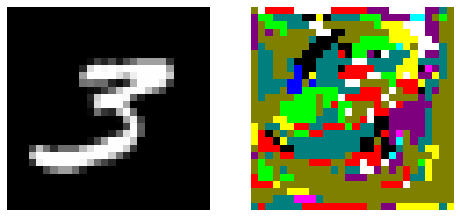

In [5]:
# 画像表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 2, 1
# 画像
figure.add_subplot(cols, rows, 1)
plt.axis("off")
plt.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
# マスク画像
figure.add_subplot(cols, rows, 2)
plt.axis("off")
masks = model(imgs)
plt.imshow(set_color(masks[0].detach().numpy().argmax(axis = 0)), cmap = "gray")
plt.show()

epoch : 1
loss_train : 0.249719
loss_test  : 0.083218
epoch : 2
loss_train : 0.058207
loss_test  : 0.041832
epoch : 3
loss_train : 0.035087
loss_test  : 0.029764
epoch : 4
loss_train : 0.026291
loss_test  : 0.023417
epoch : 5
loss_train : 0.021545
loss_test  : 0.020469


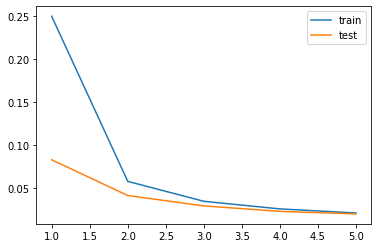

In [6]:
for epoch in range(5): # エポック数分ループを回す
    loss_train = 0.0
    acc_train = 0.0
    loss_test = 0.0
    acc_test = 0.0
    
    # 学習
    for (x, t) in train_dataloader:
        # パラメータの勾配をリセット
        model.optimizer.zero_grad()
        # 順伝搬＋逆伝搬＋パラメータ更新
        y = model(x)
        loss = model.loss(y, t[:, 0, :, :])
        loss.backward()
        model.optimizer.step()
        # 統計情報の記録
        loss_train += loss.item()
        #acc_train += sum(y.argmax(axis=1) == t) / len(t)
        
    # 検証
    with torch.no_grad(): # テストでは勾配を求める必要がないので、勾配を求めないように設定
        for x, t in test_dataloader:
            y = model(x)
            loss = model.loss(y, t[:, 0, :, :])
            loss_test += loss.item()
            #acc_test += sum(y.argmax(axis=1) == t) / len(t)
            
    # 結果の記録・表示
    model.loss_train_log.append(loss_train / len(train_dataloader))
    model.loss_test_log.append(loss_test / len(test_dataloader))
    print(f"epoch : {epoch + 1}")
    print(f"loss_train : {model.loss_train_log[-1]:.06f}")
    print(f"loss_test  : {model.loss_test_log[-1]:.06f}")
        
# Lossのログ表示
plt.plot(range(1, len(model.loss_train_log) + 1), model.loss_train_log, label = "train")
plt.plot(range(1, len(model.loss_test_log) + 1),  model.loss_test_log,  label = "test")
plt.legend(loc = "upper right") # 凡例表示
torch.save(model, "../../model/SemanticSegmentation-mnist.pth") # モデルの保存

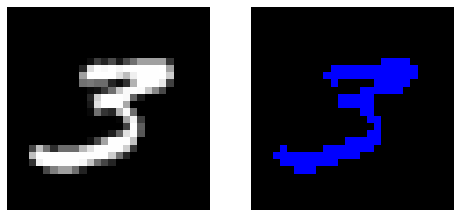

In [7]:
# 画像表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 2, 1
# 画像
figure.add_subplot(cols, rows, 1)
plt.axis("off")
plt.imshow(imgs[0].squeeze().numpy(), cmap = "gray")
# マスク画像
figure.add_subplot(cols, rows, 2)
plt.axis("off")
masks = model(imgs)
plt.imshow(set_color(masks[0].detach().numpy().argmax(axis = 0)), cmap = "gray")
plt.show()